# Deconstructing Image Neural Networks

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Using fastai v0.7 (highest abstraction)
First let's just make a simple image neural netowrk using the old fastai-v0.7 library.

In [7]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *
from fastai.dataset import *

### Using application ```create_cnn```
Let's start by analyzing the MNIST data, and using the simplest method for quickly creating a CNN in the fastai v1 lib.

In [3]:
mnist = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)

It's set up with an imagenet structure so we use it to load our training and validation datasets, then label, transform, convert them into ImageDataBunch and finally, normalize them.

In [97]:
data = (ImageItemList.from_folder(mnist)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats))

Once your data is properly set up in a ```DataBunch```, we can call ```data.show_batch()``` to see what a sample of a batch looks like.

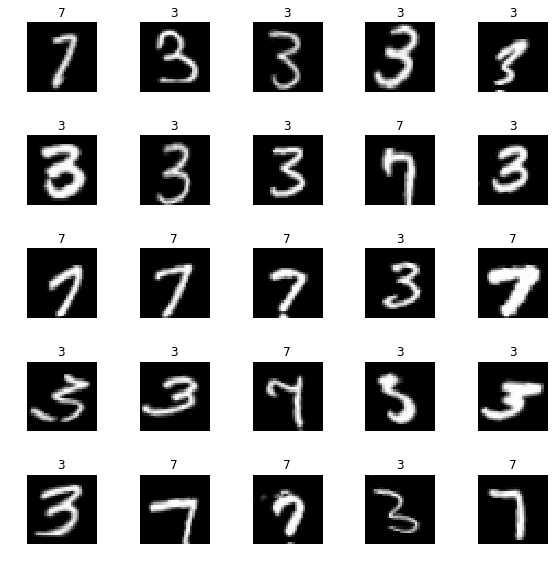

In [25]:
data.show_batch(figsize=(8,8))

Note that the images were automatically de-normalized before being showed with their labels (inferred from the names of the folder). We can specify a number of rows if the default of 5 is too big, and we can also limit the size of the figure

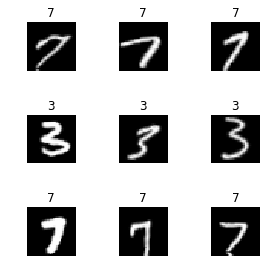

In [15]:
data.show_batch(rows=3, figsize=(4,4))

Now let's create a ```Learner``` object to train a classifier.

In [16]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,accuracy
1,0.537274,0.136335,0.947067


Our model has quickly reache around 95% accuracy, now let's see its predictions on a sample of the validation set. For this, we use the ```show_results``` method.

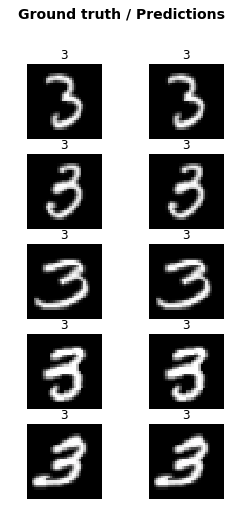

In [23]:
learn.show_results(figsize=(4,8))

Since the validation set is usually sorted, we get only images belonging to the same class. We can then again specify a number of rows, a figure size, but also the dataset on which we want to make predictions.

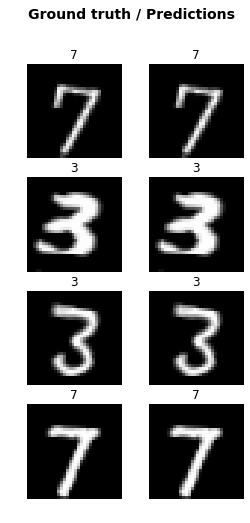

In [18]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(4,8))

### Manually creating CNN with ```simple_cnn```
Above we used an ```application``` in the fastai v1 library to quickly create a pretrained neural net. That was the ```create_cnn``` line. If we step down one level lower in abstraction, we can manually create minimally simple CNNs in fastai v1 using ```simple_cnn```.

In [82]:
model = simple_cnn((3,16,16,2))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Lambda()
  )
)

The most important object for training models is ```Learner```, which needs to know, at minimum, what data to train with and what model to train.

In [28]:
learn = Learner(data,model)

That's enough to train a model, which is done using ```fit```. If you have a CUDA-capable GPU it will be used automatically. You have to say how many epochs to train for.

In [30]:
learn.fit(1)

epoch,train_loss,valid_loss
1,0.656956,0.548419


To see how our training is going, we can request that it reports various metrics after each epoch. You can pass it to the constructor, or set it later. Note that metrics are always calculated on the validation set.

In [31]:
learn.metrics=[accuracy]
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,0.600006,0.496767,0.494993


You can use callbacks to modify training in almost any way you can imagine. For instance, we've provided a callback to implement Leslie Smith's 1cycle training method.

In [33]:
from fastai.callbacks import *
cb = OneCycleScheduler(learn, lr_max=0.01)
learn.fit(1, callbacks=cb)

epoch,train_loss,valid_loss,accuracy
1,0.575662,0.476168,0.494993


The Recorder callback is automatically added for you, and you can use it to see what happened in your training, e.g.:

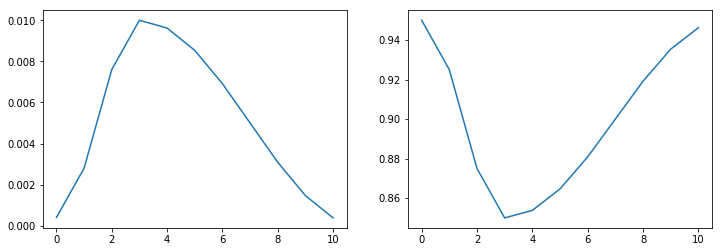

In [34]:
learn.recorder.plot_lr(show_moms=True)

Many of the callbacks can be used more easily by taking advantage of the ```Learner``` extensions in ```train```. For instance, instead of creating OneCycleScheduler manually as above, you can simply call ```Learner.fit_one_cycle```:

In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.567200,0.466994,0.494993


## Using pytorch
Well that was super simple! Let's see what this process looks like using less fastai v1 and increasingly more pytorch. This borrows heavily from the fastai ml1 lesson #9 (lesson #4 SGD notebook).

### Pytorch defined net with fastai v1 defined training

In [1]:
import torch.nn as nn

In [5]:
net = nn.Sequential(
    nn.Linear(28*28,100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
).cuda()

In [8]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

NameError: name 'path' is not defined

In [17]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [36]:
fit(model=net, data=data, epochs=5, loss_func=loss, opt=opt, metrics=metrics)

### User defined net, Pytorch defined optimizer, fastai v1 defined training

Above we used pytorch's ```nn.Linear``` to create a linear layer. This is defined as matrix multiplication and then an addition (these are also called affine transformations). Let's try building this ourselves.

Just as Numpy has ```np.matmul``` for matrix multiplication (in Python 3, this is equivalent to the ```@``` operator), PyTorch has ```torch.matmul```.

Our PyTorch class needs two things: constructor (says what the parameters are) and a ```forward``` method (how to calculate a prediction using those parameters) The method forward describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type ```Parameter```.

In [43]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.ll_w = get_weights(3*28*28, 10) # Layer 1 weights
        self.ll_b = get_weights(10)        # Layer 1 bias
    
    def forward(self,x): #Describes how to get outputs from inputs
        x = x.view(x.size(0), -1)
        x = (x @ self.ll_w) + self.ll_b #Linear Layer
        x = torch.log(softmax(x)) #Non-linear softmax layer
        return x
    

Now that we've defined our net, let's use pytorch to determine how we optimize it and fastai to train it!

In [44]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())
fit(model=net2, data=data, epochs=5, loss_func=loss, opt=opt, metrics=metrics)

### User defined net and training, Pytorch defined optimizer

Now instead of using fastai's fit function, let's create our own training loop.

In [55]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
opt=optim.Adam(net2.parameters())

for epoch in range(1):
    losses=[]
    dl = iter(data.train_dl)
    for t in range(len(dl)):
        # Forward pass through the net. Make sure to put xt and yt as varaibles (V) so that pytorch can differentiate them!
        xt,yt = next(dl)
        pred_yt = net2(V(xt))
        l = loss(pred_yt,V(yt))
        losses.append(l)
        
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
    val_dl = iter(data.valid_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

TypeError: object of type 'generator' has no len()

In [60]:
next(data.dls)

TypeError: 'list' object is not an iterator